# <center>Convolutional Neural Networks</center>
## <center>Inclass Project 4 - MA4144</center>

This project contains 5 tasks/questions to be completed, some require written answers. Open a markdown cell below the respective question that require written answers and provide (type) your answers. Questions that required written answers are given in blue fonts. Almost all written questions are open ended, they do not have a correct or wrong answer. You are free to give your opinions, but please provide related answers within the context.

After finishing project run the entire notebook once and **save the notebook as a pdf** (File menu -> Save and Export Notebook As -> PDF). You are **required to upload this PDF on moodle**.

***

## Outline of the project

The aim of the project is to practically learn and implement about CNN. This project will have two main sections.

Section 1: Build a convolutional layer and pooling layer from scratch. Then test them on a sample image.

Section 2: Use the Keras library to implement a CNN to classify images on the [CIFAR10 dataset](https://www.cs.toronto.edu/~kriz/cifar.html).

***


Use the below cell to use any include any imports

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import random
from keras.preprocessing.image import load_img
import keras
from keras import layers
from sklearn.model_selection import KFold
from sklearn.metrics import confusion_matrix, classification_report
from keras.regularizers import l2
from sklearn.utils import class_weight
from keras.callbacks import ReduceLROnPlateau, EarlyStopping

## Section 1: Convolution and Pooling

**Q1** In the following cell, implement a method called create_padding. The method will take in input_image ($n \times m$) and will return a zero-padded image called output_image of dimension $(n + 2d) \times (m + 2d)$ where $d$ is the padding thickness on either side.

In [2]:
def create_padding(input_image, d):
    input_image = np.array(input_image)
    #get the dimensions of the input image
    n, m, c = input_image.shape

    # create tesnor of zeros and replace middle part with the image
    output_image = np.zeros((n+2*d , m+2*d, c)).astype(input_image.dtype)
    output_image[d:n+d, d:m+d, :] = input_image

    return output_image


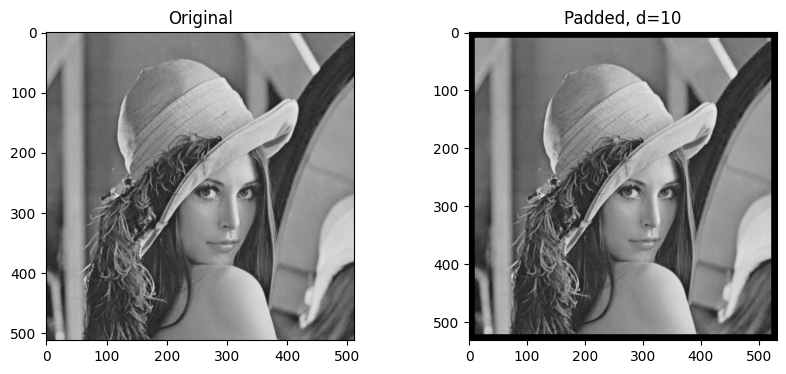

In [3]:
image = load_img('/kaggle/input/images/lena.gif')
padded_img = create_padding(image, d=10)

fig, ax = plt.subplots(1,2, figsize = (10,4))
ax[0].imshow(image)
ax[0].set_title('Original')

ax[1].imshow(padded_img)
ax[1].set_title('Padded, d=10')
plt.show()

**Q2** In the following cell, implement a method called convolution. The method will take in input_image ($n \times m$), kernel ($k \times k$) and will return output_image of dimension $(n - k + 1) \times (m - k + 1)$. The output_image is the result of the convolution between input_image and kernel. You may assume that the stride is $1$.

In [4]:
def convolution(input_image, kernel):
    # Conver to numpy array
    input_image = np.array(input_image)

    # Ensure oth image and kernel are same datatype
    kernel = np.expand_dims(kernel, -1)

    # Extract shapes of the matrices
    k,_,_ = kernel.shape
    n, m, c = input_image.shape

    # Initialize a matrix with zeros
    output_image = np.zeros((n-k+1, m-k+1, c))

    # Perform convolution
    for i in range (n-k+1):
        for j in range (m-k+1):
            img_patch = input_image[i:i+k, j:j+k, :]
            output_image[i, j, :] = np.sum(img_patch*kernel, axis=(0,1))

    # Adjust the pixel intensity range to [0, 1]
    out_min = np.min(output_image,axis=(0,1))
    out_max = np.max(output_image,axis=(0,1))
    output_image = (output_image - out_min)/(out_max - out_min + 1e-8)
    
    
    return output_image

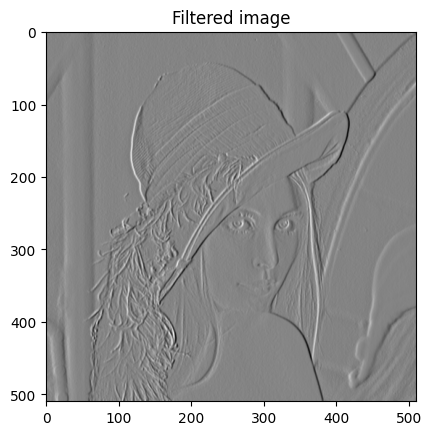

In [5]:
kernel = np.array([[-1,0,1],[-2,0,2],[-1,0,1]])
output = convolution(image, kernel)

plt.imshow(output, cmap = 'gray')
plt.title('Filtered image')
plt.show()

**Q3** In the following cell, implement a method called pooling. The method will take in input_image ($n \times m$), $p$ the pooling dimension, pooling_type (either max_pooling or avg_pooling) and will return output_image of dimension $(n - p + 1) \times (m - p + 1)$. The output_image is the result of performing pooling on input_image by a window of dimension $p \times p$. You may assume that the stride is $1$.

In [6]:
def pooling(input_image, p, pooling_type = "max_pooling"):
    n, m, c = np.array(input_image).shape
    output_image = np.zeros((n-p+1, m-p+1, c))

    if pooling_type == "max_pooling":
        for i in range(n-p+1):
            for j in range(m-p+1):
                img_patch = input_image[i:i+p, j:j+p, :]
                output_image[i,j,:] = np.max(img_patch, axis=(0,1))
        pass

    elif pooling_type == "avg_pooling":
        for i in range(n-p+1):
            for j in range(m-p+1):
                img_patch = input_image[i:i+p, j:j+p, :]
                output_image[i,j,:] = np.mean(img_patch, axis=(0,1))
        pass

    else:
        print("Error: Invalid pooling type")
        return

    return(output_image)


In [7]:
array1 = np.array([[[1,2,4,6],[3,9,2,0],[7,6,1,8], [6,2,9,4]],
                   [[1,2,4,6],[3,9,2,0],[7,6,1,8], [6,2,9,4]],
                   [[1,2,4,6],[3,9,2,0],[7,6,1,8], [16,2,9,4]]])

array = array1.transpose(1,2,0)
out_max = pooling(array, 2, pooling_type = "max_pooling")
out_avg = pooling(array, 2, pooling_type = "avg_pooling")

print('Input:\n', array[:,:,1])
print('\nMax pooloing output:\n', out_max[:,:,1])
print('\nAverage pooloing output:\n', out_avg[:,:,1])

Input:
 [[1 2 4 6]
 [3 9 2 0]
 [7 6 1 8]
 [6 2 9 4]]

Max pooloing output:
 [[9. 9. 6.]
 [9. 9. 8.]
 [7. 9. 9.]]

Average pooloing output:
 [[3.75 4.25 3.  ]
 [6.25 4.5  2.75]
 [5.25 4.5  5.5 ]]


The 'lena' image is widely used for image processing experiments and has been a benchmark image until recently.
We will use a $512 \times 512$ grayscale lena sample to test our convolution and pooling implementations.

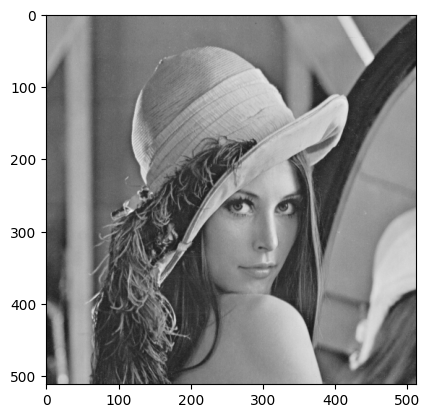

In [8]:
lena = load_img('/kaggle/input/images/lena.gif')
plt.imshow(lena)
plt.show()

**Q4** In the following perform convolution on lena. Make sure you use padding appropriately to maintain the image size after convolution. However, pooling should be done on an unpadded image and image size may not be preseved after pooling. Use the following kernels to perform convolution separately.

1. $\begin{bmatrix} +1 & 0 & -1 \\ +1 & 0 & -1 \\ +1 & 0 & -1 \end{bmatrix}$
   
2. $\begin{bmatrix} -1 & -1 & -1 \\ 0 & 0 & 0 \\ +1 & +1 & +1 \end{bmatrix}$

3. $\begin{bmatrix} -1 & 0 & +1 \\ -2 & 0 & +2 \\ -1 & 0 & +1 \end{bmatrix}$

4. $\begin{bmatrix} +1 & +2 & +1 \\ 0 & 0 & 0 \\ -1 & -2 & -1 \end{bmatrix}$

5. Any other kernel that you may find interesting.

<font color='blue'>Explain what the above kernels (including your choice) will do to the image.</font>

**Answer**

<font color='darkblue'> Each of the above kernels apply a specific filter to the image.</font>

*   <font color='darkblue'>kernel 1 : Prewitt horizontal kernel. Emphasizes vertical edges of the image and filters out the horizontal edges
*   kernel 2 : Prewitt vertical kernel. Emphasizes horizontal edges of the image and filters out the vertical edges
*   kernel 3 : Sobel horizontal kernel. Emphasizes vertical edges of the image and filters out the horizontal edges
*   kernel 4 : Sobel vertical kernel. Emphasizes horizontal edges of the image and filters out the vertical edges
*   kernel 5 : Homogeneous blur kernel. Blurs the image


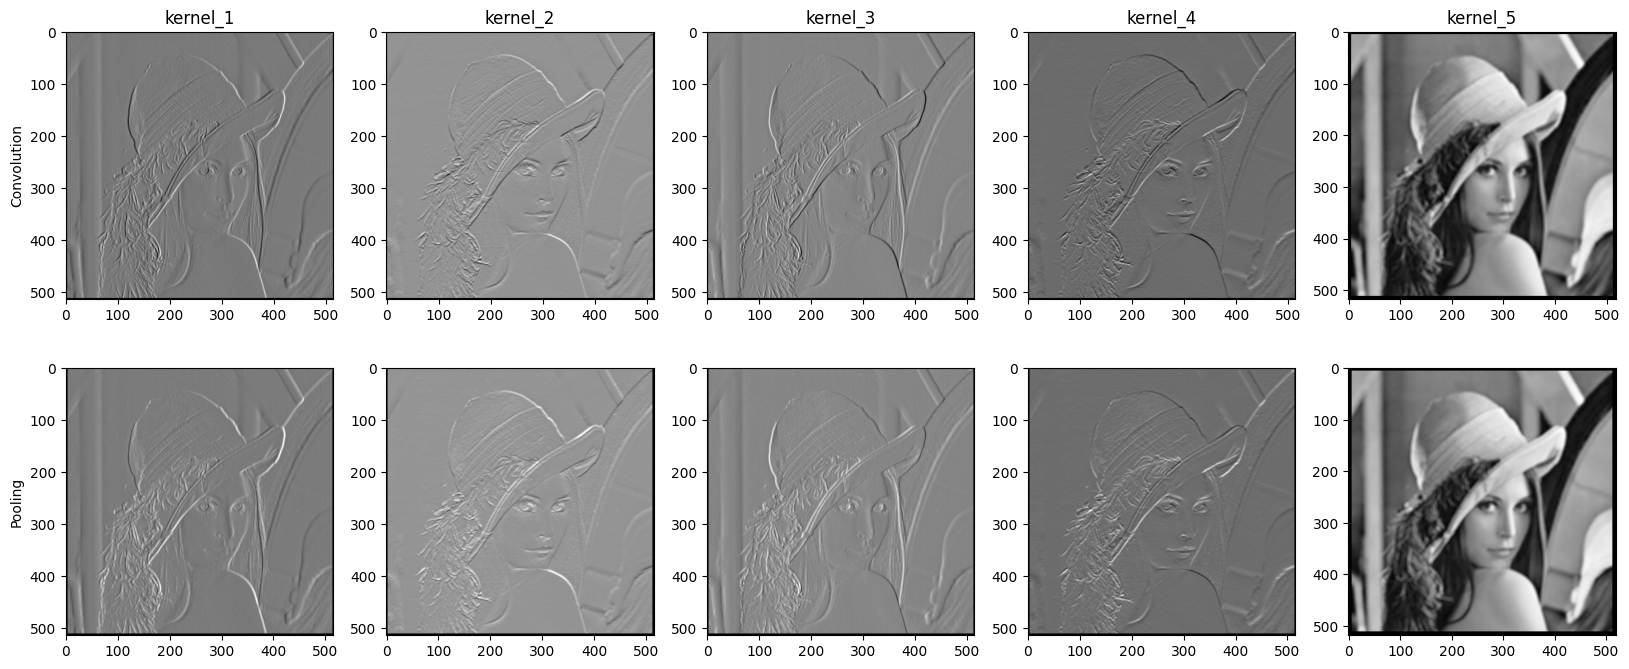

In [9]:
# Define kernels
kernel_1 = np.array([[1,0,-1],[1,0,-1],[1,0,-1]])
kernel_2 = np.array([[-1,-1,-1],[0,0,0],[1,1,1]])
kernel_3 = np.array([[-1,0,1],[-2,0,2],[-1,0,1]])
kernel_4 = np.array([[1,2,1],[0,0,0],[-1,-2,-1]])
kernel_5 = np.ones((7,7))/49 # Blur kenel

kernel_list = [kernel_1 , kernel_2, kernel_3, kernel_4, kernel_5]

n, m = lena.size

fig, ax = plt.subplots(2,5, figsize=(20,8))

# Perform convolution and pooling for each kernel
for i in range (5):
    kernel = kernel_list[i]

    conv_img = convolution(lena, kernel)
    n_conv, m_conv, _ = conv_img.shape

    # Find the padding size, d_conv
    d_conv = n - n_conv

    # Pad convolved image
    padded_conv_img = create_padding(conv_img, d=d_conv)

    # Perform pooling (max pooling) with p = 2
    pooled_img = pooling(conv_img, p=2, pooling_type = "max_pooling")
    n_pool, m_pool, _ = pooled_img.shape

    # Find the padding size, d_pool
    d_pool = n - n_pool

    # Pad pooling output image
    padded_pooled_img = create_padding(pooled_img, d=d_pool)

    # Plot the results
    ax[0, i].imshow(padded_conv_img, cmap = 'gray')
    ax[0, i].set_title(f'kernel_{i+1}')
    ax[1, i].imshow(padded_pooled_img, cmap = 'gray')

ax[0,0].set_ylabel('Convolution')
ax[1,0].set_ylabel('Pooling')
plt.show()

Show the resulting image after convolution and pooling separately on two subplots (of the same plot) for each kernel. There should be 5 plots with two sub plots in each.

<font color='blue'>Comment on the results of the above experiment. Mention whether you think the experiment was successful, and what your learnt from it.</font>

**Answer**

* <font color='darkblue'> The convolution operation has been successfully applied on the image. The first four kernels have tried to detect edges of the image. The last kernel has also worked well. Padding also has worked correctly.</font>

* <font color='darkblue'>Maxpooling has tried to emphasize the prominent features of each convolution output image meaning that it also has worked correctly. </font>

* <font color='darkblue'>We can use convolution operation to emphasize/detect different features of images. The feature that is detected/ emphasized is dependent on the convolution kernel we use.</font>

## Section 2: Using Keras to implement CNN for image classification

This section, unlike the previous projects you are granted full liberty to build the structure of your project appropriately using keras. I have provided only the code to download the cifar10 dataset. After using CNN on the dataset, provide the following. (Note that cifar10 contains rgb images with 3 channels unlike the grayscake image lena we used earlier.)

1. 5-fold cross validation accuracy.
2. Testing accuracy.
3. Confusion matrix of the result.
4. Precision recall for each class.

Note: You are required test on different hyperparameters and network architectures and select decide the best performer based on the cross-validation accuracy.

In [10]:
(x_train, y_train), (x_test, y_test) = keras.datasets.cifar10.load_data()

170498071/170498071 ━━━━━━━━━━━━━━━━━━━━ 3s 0us/step


In [11]:
print('Train dataset size: ',x_train.shape)

Train dataset size:  (50000, 32, 32, 3)


In [33]:
class CNN_Model_4(keras.Model):
    def __init__(self, num_classes, dropout=0.5, l2_lambda=0.0025):
        super(CNN_Model_4, self).__init__()

        self.num_classes = num_classes
        self.dropout = dropout
        self.l2_lambda = l2_lambda
        
        # CNN feature extractor
        self.cnn =  keras.Sequential([
            layers.Conv2D(64, (3, 3), activation='relu'),
            layers.BatchNormalization(),
            layers.Dropout(self.dropout),
            
            layers.Conv2D(128, (3, 3), activation='relu'),
            layers.BatchNormalization(),
            layers.MaxPooling2D((2, 2)),
            layers.Dropout(self.dropout),
            
            layers.Conv2D(256, (3, 3), activation='relu', kernel_regularizer=l2(self.l2_lambda)),
            layers.BatchNormalization(),
            layers.MaxPooling2D((2, 2)),
            layers.Dropout(self.dropout),
            
            layers.Conv2D(512, (3, 3), activation='relu', kernel_regularizer=l2(self.l2_lambda)),
            layers.BatchNormalization(),
            layers.MaxPooling2D((2, 2)),
            layers.Dropout(self.dropout),
            layers.Flatten()
        ])

        # MLP head
        self.classifier = keras.Sequential([
            layers.Dense(256, activation = 'relu', kernel_regularizer=l2(self.l2_lambda)),
            layers.BatchNormalization(),
            layers.Dropout(self.dropout),
            
            layers.Dense(128, activation = 'relu', kernel_regularizer=l2(self.l2_lambda)),
            layers.BatchNormalization(),
            layers.Dropout(self.dropout),
            
            layers.Dense(self.num_classes, activation = 'softmax')
        ])

    def call(self, inputs):
        feats = self.cnn(inputs)
        output = self.classifier(feats)

        return output

In [34]:
# Function to normalize the datasets
def normalize_data(img):
    return img/255


# Function to train the model
def train_model(x_train, y_train, epochs=100, num_classes=10, batch_size=128, learning_rate=0.001, dropout=0.5, kfolds=5):
    #Normalize train image dataset
    norm_x_train = normalize_data(x_train)

    folds = KFold(n_splits = kfolds)

    total_predictions = []
    total_labels =[]
    
    for train_idx, val_idx in folds.split(norm_x_train):
        X_train, X_val = norm_x_train[train_idx] , norm_x_train[val_idx]
        Y_train, Y_val = y_train[train_idx], y_train[val_idx]
        
        # One-hot-encode labels
        y_train_onehot = keras.utils.to_categorical(Y_train, num_classes)
        y_val_onehot = keras.utils.to_categorical(Y_val, num_classes)

        # Initialize the optimizer
        optimizer=keras.optimizers.Adam(learning_rate=learning_rate, weight_decay = 1e-4)
        reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.75, patience=5, min_lr=1e-6)
        early_stopping = EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True)
        
        # Initialize the model
        model = CNN_Model_4(num_classes, dropout)
        model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

        # Train the model
        model.fit(X_train, y_train_onehot,
                  epochs=epochs, batch_size=batch_size,
                  verbose=0, shuffle=True,
                  validation_data=(X_val, y_val_onehot),
                  callbacks=[reduce_lr, early_stopping])

        # Compute validation accuracy and loss
        val_loss, val_accuracy = model.evaluate(X_val, y_val_onehot, verbose=0)
        print(f'Validation loss = {val_loss} , accuracy = {val_accuracy}')
        
        # Cross validation
        predictions = model.predict(X_val)
        pred_class = np.argmax(predictions, axis=1)

        total_predictions.extend(pred_class)
        total_labels.extend(Y_val)

    # Compute the confusion matrix and display it
    confusion_mat = confusion_matrix(total_labels, total_predictions)
    print('Confusion matrix:\n',confusion_mat)

    # Classification report for precision and recall
    print(classification_report(total_labels, total_predictions, target_names=[str(i) for i in range(num_classes)]))
    
    return model



# Function to test the model
def evaluate(model, x_test, y_test, num_classes=10):
    #initialize inputs and labels
    normalized_x_test = normalize_data(x_test)
    y_test_onehot = keras.utils.to_categorical(y_test, num_classes)
    
    #predic classes
    predictions = model.predict(normalized_x_test)
    pred_class = np.argmax(predictions, axis=1)
    
    
    confusion_mat = confusion_matrix(y_test, pred_class)
    print('Confusion matrix:\n',confusion_mat)

    # Classification report for precision and recall
    print('\nClassification reort:\n')
    print(classification_report(y_test, pred_class, target_names=[str(i) for i in range(num_classes)]))
   
    

In [35]:
model = train_model(x_train, y_train, epochs=40, batch_size=128, learning_rate=0.001, dropout=0.35, kfolds=5)

Validation loss = 0.936316728591919 , accuracy = 0.7842000126838684
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
Validation loss = 0.9532339572906494 , accuracy = 0.7649000287055969
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
Validation loss = 0.9240343570709229 , accuracy = 0.7838000059127808
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
Validation loss = 0.9649398326873779 , accuracy = 0.7573000192642212
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
Validation loss = 0.9179961085319519 , accuracy = 0.7818999886512756
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
Confusion matrix:
 [[4025   81  239   83   61   22   23   53  257  156]
 [  90 4502   15   21    6   19   16   17   95  219]
 [ 350   29 3424  295  260  195  206  159   60   22]
 [ 103   20  267 3138  203  740  191  202   72   64]
 [ 134    9  353  282 3588  147  136  317   21   13]
 [  34   18  192  887  167 3323   72  267   18   22]
 [  41   38  275  294  134   92 4040   31   28   27]
 [  73   14  144  178  191  186   19 4132   21   42]
 [ 323  

In [36]:
# Model performance on the test set
evaluate(model, x_test, y_test, num_classes=10)

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
Confusion matrix:
 [[694  43  60  28  16   2   3   9  98  47]
 [  4 927   4   2   2   5   3   2  11  40]
 [ 38   5 699  56  52  65  33  35  10   7]
 [ 17  12  63 622  46 113  48  48  14  17]
 [ 12   2  69  52 765  18  25  49   7   1]
 [  2   2  39 182  31 661  18  58   3   4]
 [  5   4  60  65  19  15 816   6   9   1]
 [  5   3  29  25  42  46   5 835   2   8]
 [ 33  48   7   7   4   4   3   3 864  27]
 [ 13  70   2   8   5   5   7   8  16 866]]

Classification reort:

              precision    recall  f1-score   support

           0       0.84      0.69      0.76      1000
           1       0.83      0.93      0.88      1000
           2       0.68      0.70      0.69      1000
           3       0.59      0.62      0.61      1000
           4       0.78      0.77      0.77      1000
           5       0.71      0.66      0.68      1000
           6       0.85      0.82      0.83      1000
           7       0.79      0.83      0.81      100

### Best hyperparameter combination found

lerning rate = 0.001

epochs = 40

batch size = 128

dropout = 0.35

l2_lambda = 0.0025

### Finding the best model architecture and the best combination of hyperparameters

Given below is the testing and finetuning process carried out to find the best mode and parameters.

In [14]:
# Define the CNN models

# Version 1
class CNN_Model_1(keras.Model):
    def __init__(self, num_classes, dropout=0.5, l2_lambda=0.0025):
        super(CNN_Model_1, self).__init__()

        self.num_classes = num_classes
        self.dropout = dropout
        self.l2_lambda = l2_lambda
        
        # CNN feature extractor
        self.cnn =  keras.Sequential([
            layers.Conv2D(32, (3, 3), activation='relu', kernel_regularizer=l2(self.l2_lambda)),
            layers.MaxPooling2D((2, 2)),
            layers.Conv2D(64, (3, 3), activation='relu', kernel_regularizer=l2(self.l2_lambda)),
            layers.Conv2D(128, (3, 3), activation='relu', kernel_regularizer=l2(self.l2_lambda)),
            layers.Flatten()
        ])

        # MLP head
        self.classifier = keras.Sequential([
            layers.Dropout(self.dropout),
            layers.Dense(self.num_classes, activation = 'softmax')
        ])

    def call(self, inputs):
        feats = self.cnn(inputs)
        output = self.classifier(feats)

        return output


    
#-----------------------------------------------------------------------------------------------------------

# Version 2
class CNN_Model_2(keras.Model):
    def __init__(self, num_classes, dropout=0.5, l2_lambda=0.0025):
        super(CNN_Model_2, self).__init__()

        self.num_classes = num_classes
        self.dropout = dropout
        self.l2_lambda = l2_lambda
        
        # CNN feature extractor
        self.cnn =  keras.Sequential([
            layers.Conv2D(16, (3, 3), activation='relu', kernel_regularizer=l2(self.l2_lambda)),
            layers.Conv2D(32, (3, 3), activation='relu', kernel_regularizer=l2(self.l2_lambda)),
            layers.Conv2D(64, (3, 3), activation='relu', kernel_regularizer=l2(self.l2_lambda)),
            layers.MaxPooling2D((2, 2)),
            layers.Flatten()
        ])

        # MLP head
        self.classifier = keras.Sequential([
            layers.Dropout(self.dropout),
            layers.Dense(self.num_classes, activation = 'softmax')
        ])

    def call(self, inputs):
        feats = self.cnn(inputs)
        output = self.classifier(feats)

        return output


#-----------------------------------------------------------------------------------------------------------

# Version 3
class CNN_Model_3(keras.Model):
    def __init__(self, num_classes, dropout=0.5, l2_lambda=0.0025):
        super(CNN_Model_3, self).__init__()

        self.num_classes = num_classes
        self.dropout = dropout
        self.l2_lambda = l2_lambda
        
        # CNN feature extractor
        self.cnn =  keras.Sequential([
            layers.Conv2D(64, (3, 3), activation='relu', kernel_regularizer=l2(self.l2_lambda)),
            layers.MaxPooling2D((2, 2)),
            layers.Conv2D(128, (3, 3), activation='relu', kernel_regularizer=l2(self.l2_lambda)),
            layers.Flatten()
        ])

        # MLP head
        self.classifier = keras.Sequential([
            layers.Dropout(self.dropout),
            layers.Dense(self.num_classes, activation = 'softmax')
        ])

    def call(self, inputs):
        feats = self.cnn(inputs)
        output = self.classifier(feats)

        return output
    
    
#-----------------------------------------------------------------------------------------------------------


# Version 4
class CNN_Model_4(keras.Model):
    def __init__(self, num_classes, dropout=0.5, l2_lambda=0.0025):
        super(CNN_Model_4, self).__init__()

        self.num_classes = num_classes
        self.dropout = dropout
        self.l2_lambda = l2_lambda
        
        # CNN feature extractor
        self.cnn =  keras.Sequential([
            layers.Conv2D(64, (3, 3), activation='relu'),
            layers.BatchNormalization(),
            layers.Dropout(self.dropout),
            
            layers.Conv2D(128, (3, 3), activation='relu'),
            layers.BatchNormalization(),
            layers.MaxPooling2D((2, 2)),
            layers.Dropout(self.dropout),
            
            layers.Conv2D(256, (3, 3), activation='relu', kernel_regularizer=l2(self.l2_lambda)),
            layers.BatchNormalization(),
            layers.MaxPooling2D((2, 2)),
            layers.Dropout(self.dropout),
            
            layers.Conv2D(512, (3, 3), activation='relu', kernel_regularizer=l2(self.l2_lambda)),
            layers.BatchNormalization(),
            layers.MaxPooling2D((2, 2)),
            layers.Dropout(self.dropout),
            layers.Flatten()
        ])

        # MLP head
        self.classifier = keras.Sequential([
            layers.Dense(256, activation = 'relu', kernel_regularizer=l2(self.l2_lambda)),
            layers.BatchNormalization(),
            layers.Dropout(self.dropout),
            
            layers.Dense(128, activation = 'relu', kernel_regularizer=l2(self.l2_lambda)),
            layers.BatchNormalization(),
            layers.Dropout(self.dropout),
            
            layers.Dense(self.num_classes, activation = 'softmax')
        ])

    def call(self, inputs):
        feats = self.cnn(inputs)
        output = self.classifier(feats)

        return output
    
    
    

In [15]:
# Function to normalize the datasets
def normalize_data(img):
    return img/255


# Function to train the model
def train_model(x_train, y_train, model_version, epochs=100, num_classes=10, batch_size=128, learning_rate=0.001, dropout=0.5, kfolds=5):
    #Normalize train image dataset
    norm_x_train = normalize_data(x_train)

    folds = KFold(n_splits = kfolds)

    total_predictions = []
    total_labels =[]
    
    for train_idx, val_idx in folds.split(norm_x_train):
        X_train, X_val = norm_x_train[train_idx] , norm_x_train[val_idx]
        Y_train, Y_val = y_train[train_idx], y_train[val_idx]
        
        # One-hot-encode labels
        y_train_onehot = keras.utils.to_categorical(Y_train, num_classes)
        y_val_onehot = keras.utils.to_categorical(Y_val, num_classes)

        # Initialize the optimizer
        optimizer=keras.optimizers.Adam(learning_rate=learning_rate, weight_decay = 1e-4)
        reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.75, patience=5, min_lr=1e-6)
        early_stopping = EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True)

        
        # Select the model
        if model_version==1:
            model = CNN_Model_1(num_classes, dropout)
        elif model_version==2:
            model = CNN_Model_2(num_classes, dropout)
        elif model_version==3:
            model = CNN_Model_3(num_classes, dropout)
        elif model_version==4:
            model = CNN_Model_4(num_classes, dropout)
        elif model_version==5:
            model = CNN_Model_5(num_classes, dropout)
        
        # Initialize the model
        model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

        # Train the model
        model.fit(X_train, y_train_onehot,
                  epochs=epochs, batch_size=batch_size,
                  verbose=0, shuffle=True,
                  validation_data=(X_val, y_val_onehot),
                  callbacks=[reduce_lr, early_stopping])

        # Compute validation accuracy and loss
        val_loss, val_accuracy = model.evaluate(X_val, y_val_onehot, verbose=0)
        print(f'Validation loss = {val_loss} , accuracy = {val_accuracy}')
        
        # Cross validation
        predictions = model.predict(X_val)
        pred_class = np.argmax(predictions, axis=1)

        total_predictions.extend(pred_class)
        total_labels.extend(Y_val)

    # Compute the confusion matrix and display it
    confusion_mat = confusion_matrix(total_labels, total_predictions)
    print('Confusion matrix:\n',confusion_mat)

    # Classification report for precision and recall
    print(classification_report(total_labels, total_predictions, target_names=[str(i) for i in range(num_classes)]))
    
    return model

#### Check the best model architecture keeping hyperparameters constant

In [17]:
# Model - Vesion 1
model = train_model(x_train, y_train, 1, epochs=10, batch_size=128, learning_rate=0.0001, dropout=0.4, kfolds=5)

Validation loss = 1.4048311710357666 , accuracy = 0.5670999884605408
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
Validation loss = 1.3654334545135498 , accuracy = 0.5763000249862671
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
Validation loss = 1.3634060621261597 , accuracy = 0.5789999961853027
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
Validation loss = 1.4072927236557007 , accuracy = 0.5631999969482422
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
Validation loss = 1.3697099685668945 , accuracy = 0.5838000178337097
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
Confusion matrix:
 <function confusion_matrix at 0x7e25435ce9e0>
              precision    recall  f1-score   support

           0       0.60      0.63      0.62      5000
           1       0.69      0.70      0.69      5000
           2       0.49      0.41      0.44      5000
           3       0.42      0.35      0.38      5000
           4       0.50      0.50      0.50      5000
           5       0.45      0.56      0.50      5000
      

In [18]:
# Model - Vesion 2
model = train_model(x_train, y_train, 2, epochs=10, batch_size=128, learning_rate=0.0001, dropout=0.4, kfolds=5)

Validation loss = 1.3207340240478516 , accuracy = 0.5802000164985657
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
Validation loss = 1.387172818183899 , accuracy = 0.5526999831199646
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
Validation loss = 1.3589199781417847 , accuracy = 0.5600000023841858
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
Validation loss = 1.365594506263733 , accuracy = 0.5626999735832214
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
Validation loss = 1.3614275455474854 , accuracy = 0.5604000091552734
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
Confusion matrix:
 <function confusion_matrix at 0x7e25435ce9e0>
              precision    recall  f1-score   support

           0       0.60      0.61      0.61      5000
           1       0.66      0.70      0.68      5000
           2       0.45      0.42      0.44      5000
           3       0.42      0.38      0.40      5000
           4       0.49      0.48      0.48      5000
           5       0.50      0.44      0.47      5000
        

In [19]:
# Model - Vesion 3
model = train_model(x_train, y_train, 3, epochs=10, batch_size=128, learning_rate=0.0001, dropout=0.4, kfolds=5)

Validation loss = 1.3073500394821167 , accuracy = 0.5834000110626221
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
Validation loss = 1.330020546913147 , accuracy = 0.5813000202178955
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
Validation loss = 1.301965355873108 , accuracy = 0.585099995136261
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
Validation loss = 1.3360711336135864 , accuracy = 0.5716999769210815
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
Validation loss = 1.3180201053619385 , accuracy = 0.5864999890327454
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
Confusion matrix:
 <function confusion_matrix at 0x7e25435ce9e0>
              precision    recall  f1-score   support

           0       0.60      0.64      0.62      5000
           1       0.68      0.71      0.70      5000
           2       0.47      0.47      0.47      5000
           3       0.42      0.42      0.42      5000
           4       0.57      0.43      0.49      5000
           5       0.51      0.46      0.48      5000
         

In [20]:
# Model - Vesion 4
model = train_model(x_train, y_train, 4, epochs=10, batch_size=128, learning_rate=0.0001, dropout=0.4, kfolds=5)

Validation loss = 1.5072072744369507 , accuracy = 0.6359999775886536
313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step
Validation loss = 1.5392893552780151 , accuracy = 0.6233999729156494
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
Validation loss = 1.4824192523956299 , accuracy = 0.6446999907493591
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
Validation loss = 1.5234891176223755 , accuracy = 0.6410999894142151
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
Validation loss = 1.4729373455047607 , accuracy = 0.6492999792098999
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
Confusion matrix:
 <function confusion_matrix at 0x7e25435ce9e0>
              precision    recall  f1-score   support

           0       0.60      0.72      0.66      5000
           1       0.78      0.76      0.77      5000
           2       0.49      0.56      0.52      5000
           3       0.45      0.51      0.48      5000
           4       0.63      0.48      0.54      5000
           5       0.58      0.49      0.53      5000
      

### Analysis

<font color='darkblue'> Above observations can be summarized as follows.</font>

* model \_1 : accuracy = 0.57
* model \_2 : accuracy = 0.56
* model \_3 : accuracy = 0.56
* model \_4 : accuracy = 0.64
* model \_5 : accuracy = 0.59

<font color='darkblue'> From the results, model 4 likely performs better than the others. Therefore try fine tuning hyperparameters with the model 4.</font>

In [22]:
model = train_model(x_train, y_train, 4, epochs=10, batch_size=256, learning_rate=0.0001, dropout=0.3, kfolds=5)

Validation loss = 1.8020179271697998 , accuracy = 0.5823000073432922
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
Validation loss = 1.786118507385254 , accuracy = 0.6046000123023987
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
Validation loss = 1.7606550455093384 , accuracy = 0.6072999835014343
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
Validation loss = 1.7594798803329468 , accuracy = 0.5824000239372253
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
Validation loss = 1.7500159740447998 , accuracy = 0.6025000214576721
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
Confusion matrix:
 <function confusion_matrix at 0x7e25435ce9e0>
              precision    recall  f1-score   support

           0       0.66      0.62      0.64      5000
           1       0.70      0.72      0.71      5000
           2       0.49      0.49      0.49      5000
           3       0.41      0.44      0.42      5000
           4       0.54      0.46      0.50      5000
           5       0.49      0.54      0.51      5000
       

In [23]:
model = train_model(x_train, y_train, 4, epochs=10, batch_size=128, learning_rate=0.0001, dropout=0.45, kfolds=5)

Validation loss = 1.4740058183670044 , accuracy = 0.6547999978065491
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
Validation loss = 1.5847262144088745 , accuracy = 0.6179999709129333
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
Validation loss = 1.486999750137329 , accuracy = 0.6557999849319458
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
Validation loss = 1.5233519077301025 , accuracy = 0.6312000155448914
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
Validation loss = 1.4462082386016846 , accuracy = 0.6489999890327454
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
Confusion matrix:
 <function confusion_matrix at 0x7e25435ce9e0>
              precision    recall  f1-score   support

           0       0.71      0.65      0.68      5000
           1       0.77      0.77      0.77      5000
           2       0.51      0.54      0.52      5000
           3       0.45      0.51      0.48      5000
           4       0.57      0.57      0.57      5000
           5       0.61      0.48      0.53      5000
       

In [24]:
model = train_model(x_train, y_train, 4, epochs=20, batch_size=128, learning_rate=0.0001, dropout=0.35, kfolds=5)

Validation loss = 1.236013650894165 , accuracy = 0.7077999711036682
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
Validation loss = 1.2544126510620117 , accuracy = 0.7017999887466431
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
Validation loss = 1.265219807624817 , accuracy = 0.7006000280380249
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
Validation loss = 1.262694001197815 , accuracy = 0.7028999924659729
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
Validation loss = 1.2549786567687988 , accuracy = 0.7106999754905701
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
Confusion matrix:
 <function confusion_matrix at 0x7e25435ce9e0>
              precision    recall  f1-score   support

           0       0.72      0.76      0.74      5000
           1       0.85      0.78      0.81      5000
           2       0.62      0.61      0.61      5000
           3       0.51      0.59      0.54      5000
           4       0.65      0.66      0.65      5000
           5       0.67      0.54      0.60      5000
         

In [25]:
model = train_model(x_train, y_train, 4, epochs=20, batch_size=128, learning_rate=0.0001, dropout=0.45, kfolds=5)

Validation loss = 1.222441554069519 , accuracy = 0.7002999782562256
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
Validation loss = 1.2342113256454468 , accuracy = 0.704800009727478
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
Validation loss = 1.2644283771514893 , accuracy = 0.7070000171661377
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
Validation loss = 1.2449185848236084 , accuracy = 0.7080000042915344
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
Validation loss = 1.2198318243026733 , accuracy = 0.7142000198364258
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
Confusion matrix:
 <function confusion_matrix at 0x7e25435ce9e0>
              precision    recall  f1-score   support

           0       0.71      0.74      0.73      5000
           1       0.80      0.85      0.82      5000
           2       0.65      0.57      0.61      5000
           3       0.54      0.51      0.52      5000
           4       0.66      0.66      0.66      5000
           5       0.62      0.60      0.61      5000
        

In [26]:
model = train_model(x_train, y_train, 4, epochs=30, batch_size=128, learning_rate=0.0001, dropout=0.35, kfolds=5)

Validation loss = 1.1658565998077393 , accuracy = 0.7311999797821045
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
Validation loss = 1.2218409776687622 , accuracy = 0.7091000080108643
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
Validation loss = 1.1649556159973145 , accuracy = 0.7329000234603882
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
Validation loss = 1.2425895929336548 , accuracy = 0.7184000015258789
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
Validation loss = 1.1575936079025269 , accuracy = 0.7347000241279602
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
Confusion matrix:
 <function confusion_matrix at 0x7e25435ce9e0>
              precision    recall  f1-score   support

           0       0.75      0.76      0.75      5000
           1       0.83      0.85      0.84      5000
           2       0.61      0.66      0.63      5000
           3       0.53      0.54      0.54      5000
           4       0.70      0.68      0.69      5000
           5       0.64      0.59      0.61      5000
      

In [27]:
model = train_model(x_train, y_train, 4, epochs=40, batch_size=128, learning_rate=0.0001, dropout=0.45, kfolds=5)

Validation loss = 1.178249716758728 , accuracy = 0.7279999852180481
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
Validation loss = 1.219913125038147 , accuracy = 0.7204999923706055
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
Validation loss = 1.1976487636566162 , accuracy = 0.7278000116348267
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
Validation loss = 1.2685117721557617 , accuracy = 0.7128000259399414
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
Validation loss = 1.1854329109191895 , accuracy = 0.7260000109672546
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
Confusion matrix:
 <function confusion_matrix at 0x7e25435ce9e0>
              precision    recall  f1-score   support

           0       0.79      0.73      0.76      5000
           1       0.84      0.84      0.84      5000
           2       0.62      0.65      0.63      5000
           3       0.52      0.58      0.55      5000
           4       0.67      0.69      0.68      5000
           5       0.64      0.60      0.62      5000
        

In [28]:
model = train_model(x_train, y_train, 4, epochs=50, batch_size=128, learning_rate=0.0001, dropout=0.35, kfolds=5)

Validation loss = 1.2264753580093384 , accuracy = 0.7261999845504761
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
Validation loss = 1.2724109888076782 , accuracy = 0.72079998254776
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
Validation loss = 1.1976794004440308 , accuracy = 0.7315999865531921
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
Validation loss = 1.2710095643997192 , accuracy = 0.7038999795913696
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
Validation loss = 1.2056571245193481 , accuracy = 0.7261000275611877
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
Confusion matrix:
 <function confusion_matrix at 0x7e25435ce9e0>
              precision    recall  f1-score   support

           0       0.75      0.76      0.75      5000
           1       0.82      0.85      0.83      5000
           2       0.66      0.62      0.64      5000
           3       0.53      0.57      0.55      5000
           4       0.70      0.65      0.68      5000
           5       0.65      0.58      0.61      5000
        

In [29]:
model = train_model(x_train, y_train, 4, epochs=50, batch_size=256, learning_rate=0.0001, dropout=0.5, kfolds=5)

Validation loss = 1.2564609050750732 , accuracy = 0.722100019454956
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
Validation loss = 1.375442624092102 , accuracy = 0.7002999782562256
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
Validation loss = 1.287683367729187 , accuracy = 0.7116000056266785
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
Validation loss = 1.2811192274093628 , accuracy = 0.7077999711036682
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
Validation loss = 1.2908064126968384 , accuracy = 0.6984999775886536
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
Confusion matrix:
 <function confusion_matrix at 0x7e25435ce9e0>
              precision    recall  f1-score   support

           0       0.72      0.75      0.74      5000
           1       0.82      0.83      0.82      5000
           2       0.65      0.58      0.61      5000
           3       0.52      0.54      0.53      5000
           4       0.63      0.70      0.66      5000
           5       0.64      0.56      0.60      5000
         

In [31]:
model = train_model(x_train, y_train, 4, epochs=50, batch_size=128, learning_rate=0.001, dropout=0.35, kfolds=5)

Validation loss = 0.9609330296516418 , accuracy = 0.7641000151634216
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
Validation loss = 0.9875776171684265 , accuracy = 0.7502999901771545
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
Validation loss = 0.9138595461845398 , accuracy = 0.7935000061988831
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
Validation loss = 0.9614906311035156 , accuracy = 0.7681999802589417
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
Validation loss = 0.9614714980125427 , accuracy = 0.7680000066757202
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
Confusion matrix:
 <function confusion_matrix at 0x7e25435ce9e0>
              precision    recall  f1-score   support

           0       0.76      0.81      0.78      5000
           1       0.85      0.91      0.88      5000
           2       0.66      0.67      0.67      5000
           3       0.59      0.62      0.61      5000
           4       0.75      0.73      0.74      5000
           5       0.69      0.67      0.68      5000
      

In [32]:
model = train_model(x_train, y_train, 4, epochs=35, batch_size=128, learning_rate=0.001, dropout=0.35, kfolds=5)

Validation loss = 0.9464530348777771 , accuracy = 0.7731000185012817
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
Validation loss = 0.950206458568573 , accuracy = 0.7700999975204468
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
Validation loss = 0.9328656196594238 , accuracy = 0.7791000008583069
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
Validation loss = 0.9820641875267029 , accuracy = 0.7595999836921692
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
Validation loss = 0.938021183013916 , accuracy = 0.7781000137329102
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
Confusion matrix:
 <function confusion_matrix at 0x7e25435ce9e0>
              precision    recall  f1-score   support

           0       0.79      0.79      0.79      5000
           1       0.88      0.88      0.88      5000
           2       0.68      0.68      0.68      5000
           3       0.60      0.61      0.61      5000
           4       0.75      0.75      0.75      5000
           5       0.73      0.64      0.68      5000
        

<font color='blue'>Comment on the results of the above experiment, including which classes were difficult to classify and your opinion. Mention whether you think the experiment was successful, and what your learnt from it.</font>

**Answer** 


The experiment was mostly successful. Further improvements could be achieved through advanced regularization techniques, and data augmentation.

By observing the classification report the classes 2, 3 and 5 seem to be more difficult to classify.